# Model pipeline

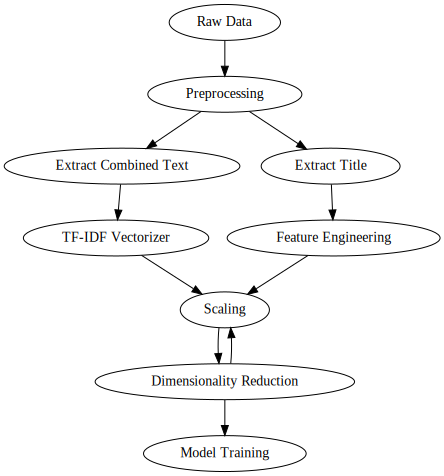

In [279]:
from graphviz import Digraph

g = Digraph('G')

g.edge('Raw Data', 'Preprocessing')
g.edge('Preprocessing', 'Extract Combined Text')
g.edge('Preprocessing', 'Extract Title')
g.edge('Extract Combined Text', 'TF-IDF Vectorizer')
g.edge('TF-IDF Vectorizer', 'Scaling')
g.edge('Scaling', 'Dimensionality Reduction')
g.edge('Extract Title', 'Feature Engineering')
g.edge('Feature Engineering', 'Scaling')
g.edge('Dimensionality Reduction', 'Scaling')
g.edge('Dimensionality Reduction', 'Model Training')

g

# Reimplementing our model with Pipelines

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/book_genre_preprocessed.csv')

In [2]:
X = df[['combined_clean','title','summary']]
#X = df['combined_clean']
y = df['genre']
print(X.shape, y.shape)

(4640, 3) (4640,)


In [4]:
from sklearn.base import TransformerMixin, BaseEstimator

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.asarray(X[self.column_name]).astype(str)

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

def chi2_tfidf(X, y, p_value_limit=0.95):
    # initialize vectorizer with 10,000 features
    tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
    X_tfidf = tfidf.fit_transform(X)
    # extract vocabulary
    dic_vocabulary = tfidf.vocabulary_
    
    # perform chi-square to determine whether a feature
    # and the binary target (e.g. Fantasy or NotFantasy)
    # are independent
    X_names = tfidf.get_feature_names_out()
    df_features = pd.DataFrame()
    for label in np.unique(y):
        chi_sq, p = chi2(X_tfidf, y==label)
        df_features = pd.concat([df_features,
                                 pd.DataFrame({
                                     "feature": X_names,
                                     "score": 1-p,
                                     "y": label
                                 })])
        df_features = df_features.sort_values(['y','score'],ascending=[True,False])
        # keep those with high-enough p-value
        df_features = df_features[df_features["score"]>p_value_limit]
    return df_features['feature'].unique().tolist()

In [135]:
from sklearn.svm import LinearSVC
svc = LinearSVC()

In [145]:
from sklearn.model_selection import train_test_split

# Split data into train/test sets
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2)

# Get the TF-IDF features that are most statistically "relevant"
tfidf_vocab = chi2_tfidf(X_train['combined_clean'], y_train)
# Initialize new TfidfVectorizer with the statistically "relevant" vocab
tfidf = TfidfVectorizer(vocabulary=tfidf_vocab)

In [147]:
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline = Pipeline([
    ('column_extractor', ColumnExtractor('combined_clean')),
    ('tfidf', tfidf), # vectorize combined text
    ('svc', svc),     # feed the output to classifier
])

In [149]:
from sklearn.metrics import accuracy_score, classification_report

model = pipeline.fit(X_train, y_train) # train the classifier
y_pred = model.predict(X_test)          # apply model to test set

score = accuracy_score(y_true, y_pred)
print (f"Accuracy: {score}")
print (classification_report(y_true, y_pred))

Accuracy: 0.6508620689655172
              precision    recall  f1-score   support

       crime       0.69      0.69      0.69        98
     fantasy       0.72      0.71      0.72       181
     history       0.64      0.71      0.67       121
      horror       0.65      0.56      0.60       115
  psychology       0.65      0.59      0.62        22
     romance       0.45      0.18      0.26        28
     science       0.68      0.64      0.66       131
      sports       0.65      0.79      0.71        14
    thriller       0.60      0.66      0.63       206
      travel       0.41      0.75      0.53        12

    accuracy                           0.65       928
   macro avg       0.61      0.63      0.61       928
weighted avg       0.65      0.65      0.65       928



In [141]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def run_experiment(X, y, pipeline, num_expts=100):
    scores = list()
    for i in range(num_expts):
        X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2)
        X_names = chi2_tfidf(X_train['combined_clean'], y_train)
        pipeline = Pipeline([
            ('column_extractor', ColumnExtractor('combined_clean')),
            ('tfidf', TfidfVectorizer(vocabulary=X_names)), # vectorize combined text
            ('svc', svc),     # feed the output to classifier
        ])
        model = pipeline.fit(X_train, y_train) # train the classifier
        y_pred = model.predict(X_test)         # apply model to test set
        score = accuracy_score(y_true, y_pred)
        scores.append(score)

    print(f"Average accuracy over {num_expts} experiments: {sum(scores) / num_expts}\n")
    print("Classification report for the last experiment:\n")
    print(classification_report(y_true, y_pred))

In [142]:
run_experiment(X, y, pipeline, num_expts=5)

Average accuracy over 5 experiments: 0.6549568965517242

Classification report for the last experiment:

              precision    recall  f1-score   support

       crime       0.72      0.66      0.69       101
     fantasy       0.71      0.74      0.73       172
     history       0.65      0.73      0.69       121
      horror       0.60      0.54      0.57       114
  psychology       0.80      0.55      0.65        22
     romance       0.46      0.22      0.30        27
     science       0.70      0.73      0.71       131
      sports       0.83      0.80      0.82        25
    thriller       0.61      0.66      0.63       196
      travel       0.67      0.63      0.65        19

    accuracy                           0.67       928
   macro avg       0.68      0.63      0.64       928
weighted avg       0.67      0.67      0.66       928



# Adding features to our pipeline

In [155]:
class Apply(BaseEstimator, TransformerMixin):
    def __init__(self, fn):
        self.fn = np.vectorize(fn)
        
    def transform(self, data):
        trans_data = self.fn(data.reshape(data.size, 1))
        return trans_data
    
    def fit(self, *_):
        return self

In [156]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')

In [157]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^\w\s]|_', '', text)
    stopwords_in_text = [w for w in text.split() if w in stop_words]
    return len(stopwords_in_text)

[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
# Split data into train/test sets
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2)

# Get the TF-IDF features that are most statistically "relevant"
tfidf_vocab = chi2_tfidf(X_train['combined_clean'], y_train)
# Initialize new TfidfVectorizer with the statistically "relevant" vocab
tfidf = TfidfVectorizer(vocabulary=tfidf_vocab)

In [238]:
class Debug(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X[0])
        print('\n')
        print(X.shape)
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self

In [250]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from mlxtend.preprocessing import DenseTransformer

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('combined', Pipeline([
            ('combined_extractor', ColumnExtractor('combined_clean')),
            ('tfidf', tfidf),
            ('scale', StandardScaler(with_mean=False)),
            #('scale', RobustScaler(with_centering=False)),
            ('to_dense', DenseTransformer()),
            ('pca', PCA(n_components=5)),
            #('dim_reduction', TruncatedSVD())
        ])),
        ('title', Pipeline([
            ('title_extractor', ColumnExtractor('title')), # extract titles
            ('title_features', FeatureUnion([
                ('title_char_count', Apply(lambda s: len(s))),
        #        ('title_word_count', Apply(lambda s: len(s.split()))),
        #        ('title_stopword_count', Apply(stopword_count))
            ])),
        ]))
    ])),
    ('scale', RobustScaler(with_centering=False)),
    ('to_dense', DenseTransformer()),
    ('pca', PCA(n_components=4)),
    ('svc', svc),     # feed the output to classifier
    #('knn', knn)
])

In [251]:
model = pipeline.fit(X_train, y_train) # train the classifier
y_pred = model.predict(X_test)          # apply model to test set

score = accuracy_score(y_true, y_pred)
print (f"Accuracy: {score}")
print (classification_report(y_true, y_pred))

moonraker several minute stood speechless eye dazzled terrible beauty greatest weapon earth he selfmade millionaire head moonraker rocket programme loved press sir hugo drax cheating card bond five day uncover sinister truth behind national hero ian fleming third 007 adventure


(3712,)
  (0, 925)	0.447650011213149
  (0, 824)	0.39605118532812117
  (0, 798)	0.4231812343788319
  (0, 313)	0.5204646549073653
  (0, 248)	0.439075291861001


(3712, 1278)
  (0, 925)	12.771181990594897
  (0, 824)	7.4163609340742145
  (0, 798)	7.0918900380472705
  (0, 313)	11.069435850442442
  (0, 248)	7.9201235032557795


(3712, 1278)
[0. 0. 0. ... 0. 0. 0.]


(3712, 1278)
[-0.11955408  0.66361594 -1.31009595 -0.76272009  0.10722529]


(3712, 5)
Moonraker


(3712,)
Moonraker


(3712,)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

## 